# Task 1

Demographic parity:

$$P(Y^*|A=Blue)/P(Y^*|A=Red) = 0.65 \cdot 2 = 1.3$$ 

$$P(Y*|A=Blue, Y=1) = \frac34$$

$$P(Y*|A=Red, Y=1) = \frac12$$


Equal opportunity:

$$P(Y^*|A=Blue, Y=1)/P(Y^*|A=Red, Y=1) = 3/4 \cdot 2 = 1.5 $$

$$P(Y|A=Blue, Y*=1) = 60/65$$

$$P(Y|A=Red, Y*=1) = \frac12$$


Predictive rate parity

$$P(Y|A=Blue, Y*=1)/P(Y|A=Red, Y*=1) = 120/65$$



In [66]:
!pip install -q interpret
!pip install -U kaleido
!pip install shap
!pip install dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libs and data preparing

In [67]:
import os
import pandas as pd

In [68]:
df = pd.read_csv('cs-training.csv')

In [69]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [70]:
import numpy as np
df = df.fillna(0)
random_permutation = np.random.permutation(df.index)
X_train = df.loc[random_permutation[:int(len(df)*0.8)]]
X_test = df.loc[random_permutation[int(len(df)*0.8):]]

y_train = X_train[['SeriousDlqin2yrs']]
y_test = X_test[['SeriousDlqin2yrs']]

X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)
X_test = X_test.drop(['SeriousDlqin2yrs'], axis=1)

In [71]:
X_test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
122238,0.414266,56,1,0.488492,4083.0,11,0,2,0,0.0
26985,0.122709,52,0,0.433499,5420.0,12,0,2,0,0.0
106745,0.158120,51,0,0.787219,11250.0,10,0,4,0,1.0
44391,0.873259,79,0,0.704793,3400.0,11,0,2,0,0.0
100802,0.132910,66,0,0.256124,6000.0,7,0,1,0,1.0


## Train Models

In [72]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

random_state = 42
ebm_search = [{'learning_rate': 0.1}]
lr_search = [{}]
xgb_search = [{}]

ebm_best = None
lr_best = None
xgb_best = None

ebm_best_score = 0
lr_best_score = 0
xgb_best_score = 0

param_search = {'EBM': ebm_search, 'RF': lr_search, 'XGB': xgb_search}
models = {'EBM': ExplainableBoostingClassifier, 'RF': LogisticRegression, 'XGB': XGBClassifier}
best_ckpts = {'EBM': ebm_best, 'RF': lr_best, 'XGB': xgb_best}
best_scores = {'EBM': ebm_best_score, 'RF': lr_best_score, 'XGB': xgb_best_score}

In [73]:
fn = lambda val: float(val)


## Selecting best model

In [74]:
for model_name in param_search.keys():
  print('Model name', model_name)  
  for params in param_search[model_name]:
    model = models[model_name](random_state=random_state, **params)
    if model_name == 'EBM':
      model.fit(X_train, y_train)
    else:
      model.fit(X_train, y_train.apply(float, axis=1))
    score = model.score(X_test, y_test)
    if score > best_scores[model_name] or best_ckpts[model_name] is None:
        best_ckpts[model_name] = model
        best_scores[model_name] = score

Model name EBM
Model name RF


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model name XGB


In [75]:
results = pd.DataFrame({'Model': ['EBM', 'RF', 'XGB'], 'Score': [best_scores['EBM'], best_scores['RF'], best_scores['XGB']]})
results

,Model,Score
0,EBM,0.935833
1,RF,0.932767
2,XGB,0.936767


Final results looks like follow.

EBM reference: https://interpret.ml/docs/ebm.html

Explainable boosting machines (EBMs) are a type of machine learning algorithm that falls into the category of boosting algorithms. Boosting algorithms are a type of ensemble learning method, which means that they combine multiple weak learners to create a stronger, more accurate model.

EBMs work by iteratively training a series of weak learners on the data, with each successive learner attempting to correct the mistakes of the previous one. At each step, the EBM assigns a weight to each training example, with more weight given to examples that were misclassified by the previous learner. This process continues until the EBM reaches a pre-defined stopping point, at which point the final model is a weighted combination of all the weak learners.

One of the key benefits of EBMs is that they are generally more explainable than other types of machine learning models. This is because the final model is a combination of relatively simple, interpretable models, which makes it easier to understand how the model is making predictions. Additionally, EBMs typically produce models that are more accurate than a single decision tree, which makes them a popular choice for many real-world applications.

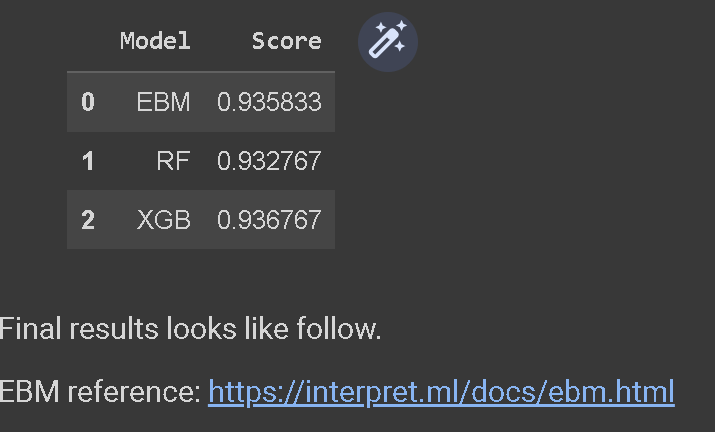

# Homework 6


# Task 2.2

In [76]:
model = best_ckpts['XGB']
import dalex as dx
explainer = dx.Explainer(model, X_test, y_test, label="XGBClassifier")
explainer.model_performance()

protected_variable = X_test.NumberOfDependents
privileged_group = 0.0

f = explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group,
)
f.fairness_check(verbose=False)


Preparation of a new explainer is initiated

  -> data              : 30000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 30000 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBClassifier
  -> predict function  : <function yhat_proba_default at 0x7ffa4f48de50> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00566, mean = 0.0672, max = 0.881
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.831, mean = -5.39e-05, max = 0.994
  -> model_info        : package xgboost

A new explainer has been created!
Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.


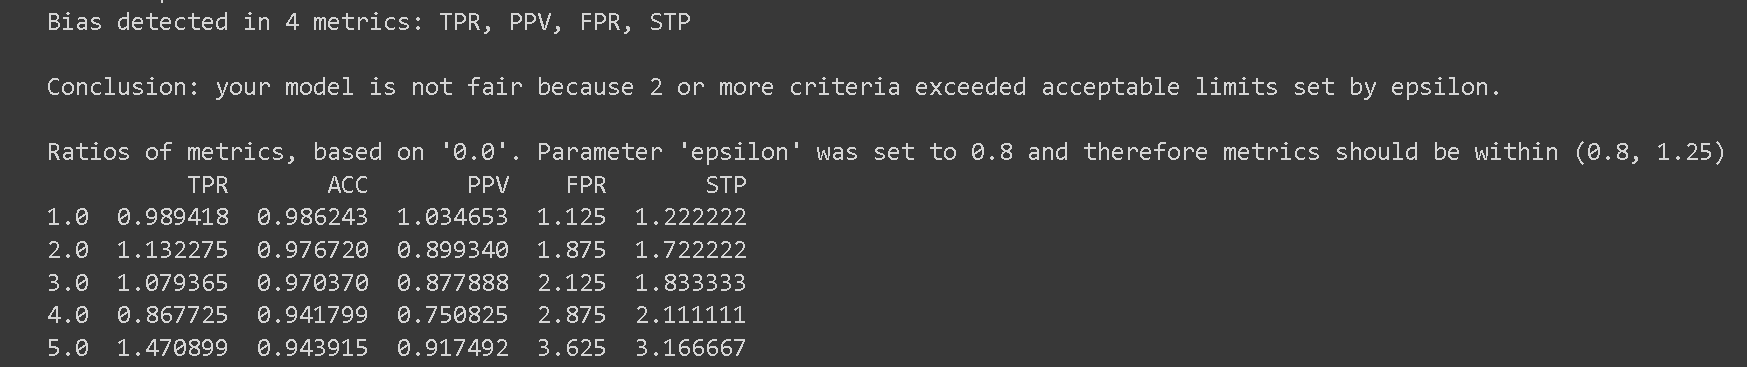

We see that at the beginning model is no so fair. Based on these results, it appears that the model is not fair because it exceeded acceptable limits set by the epsilon parameter for two or more criteria. The epsilon parameter is a measure of the acceptable amount of deviation from the ideal value for a metric, and in this case, it was set to 0.8. This means that the metrics should be within the range of (0.8, 1.25) in order to be considered fair.

However, as the results show, the model exceeded this limit for several criteria, including the true positive rate (TPR), false positive rate (FPR), and specific true positive (STP). This indicates that the model is not fair, as it is not meeting the acceptable limits for these metrics. It is worth noting that the results for the accuracy (ACC) and positive predictive value (PPV) metrics are within the acceptable range, but the overall fairness of the model is still in question due to the performance of the other metrics.

## Task 2.3

In [77]:
model = best_ckpts['EBM']
explainer_ebm = dx.Explainer(model, X_test, y_test, label="EBM")
explainer_ebm.model_performance()

protected_variable = X_test.NumberOfDependents
privileged_group = 0.0

f = explainer_ebm.model_fairness(
    protected=protected_variable,
    privileged=privileged_group,
)
f.fairness_check(verbose=False)

Preparation of a new explainer is initiated

  -> data              : 30000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 30000 values
  -> model_class       : interpret.glassbox.ebm.ebm.ExplainableBoostingClassifier (default)
  -> label             : EBM
  -> predict function  : <function yhat_proba_default at 0x7ffa4f48de50> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.003, mean = 0.0672, max = 0.898
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.896, mean = -0.000117, max = 0.994
  -> model_info        : package interpret

A new explainer has been created!
Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.



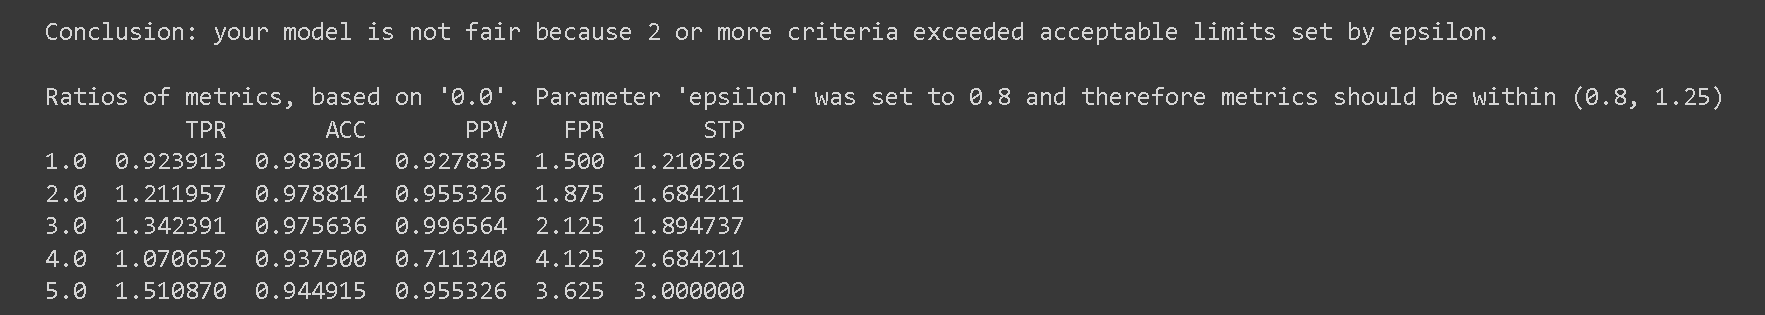

One of the key benefits of EBMs is that they are generally more explainable than other types of machine learning models. This is because the final model is a combination of relatively simple, interpretable models, which makes it easier to understand how the model is making predictions. Additionally, EBMs typically produce models that are more accurate than a single decision tree, which makes them a popular choice for many real-world applications.



## Task 2.4

In [78]:
from dalex.fairness import reweight

sample_weight = reweight(
    X_train.NumberOfDependents,
    y_train,
    verbose=True
)

model = XGBClassifier()
model.fit(X_train, y_train, sample_weight=sample_weight)
explainer_rw = dx.Explainer(model, X_test, y_test, label="XGBClassifier with reweight")
explainer_rw.model_performance()

protected_variable = X_test.NumberOfDependents
privileged_group = 0.0

f = explainer_rw.model_fairness(
    protected=protected_variable,
    privileged=privileged_group,
)
f.fairness_check(verbose=False)

Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
protected Series will be converted to np.ndarray
protected array is not string type, converting to string 


/usr/local/lib/python3.8/dist-packages/dalex/fairness/_group_fairness/mitigation.py:58: RuntimeWarning: divide by zero encountered in long_scalars
  Wsc = (Xs * Xc) / (len(y) * Xsc)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Preparation of a new explainer is initiated

  -> data              : 30000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 30000 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBClassifier with reweight
  -> predict function  : <function yhat_proba_default at 0x7ffa4f48de50> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00558, mean = 0.0671, max = 0.888
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.822, mean = 3.75e-05, max = 0.994
  -> model_info        : package xgboost

A new explainer has been created!
Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set

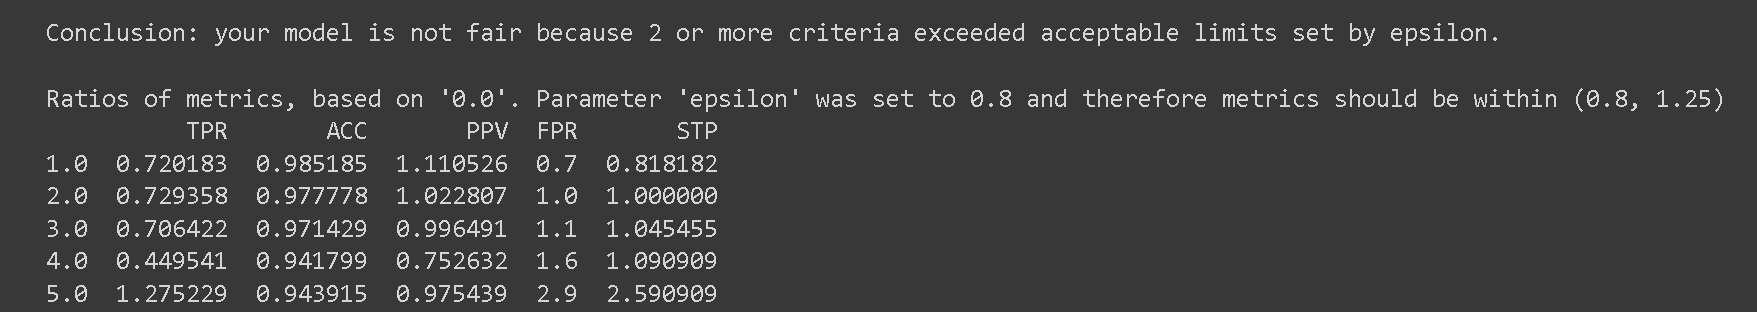

if a dataset contains data from both men and women, but there are significantly more data points for men than for women, a model trained on this dataset may be biased towards men. To mitigate this bias, the dataset can be weighted to give more importance to the data from women, so that the model pays more attention to this data and is less biased.

Overall, the use of dataset weighting can help improve the fairness of a machine learning model by giving more importance to underrepresented groups in the data, helping the model to make more balanced predictions.

In this example we see slight change towards fairness however still model is recognized as not fair with regards to algorithm.

In [79]:
pd.concat([explainer.model_performance().result, explainer_ebm.model_performance().result, explainer_rw.model_performance().result], axis=0)

,recall,precision,f1,accuracy,auc
XGBClassifier,0.193741,0.587349,0.291371,0.936767,0.862356
EBM,0.193741,0.563584,0.288355,0.935833,0.862450
XGBClassifier with reweight,0.188276,0.578626,0.284108,0.936333,0.861776


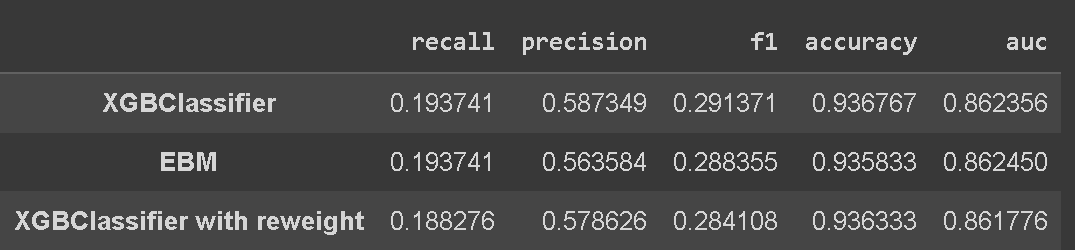

Based on these results, there does not appear to be a strong correlation between model fairness and performance. The XGBClassifier and EBM models have similar recall, precision, F1 score, accuracy, and AUC values, but the XGBClassifier with reweight model has slightly lower values for these metrics. This suggests that adding a fairness constraint to the XGBClassifier model may have reduced its overall performance, but not significantly. It is worth noting that this is only a single dataset, so these results may not be representative of the relationship between fairness and performance in general.

In second example we see that recall is particularly important in applications where false negatives (i.e. cases where the model predicts that an example is negative when it is actually positive) are more costly than false positives (i.e. cases where the model predicts that an example is positive when it is actually negative). For example, in a medical diagnostic application, it may be more important to avoid missing a positive diagnosis (i.e. a high recall) than to avoid false positives, since the consequences of failing to diagnose a patient can be more severe than wrongly diagnosing a healthy patient.

In [80]:
!jupyter nbconvert --to=html Copy_of_mt406390_xai6.ipynb

[NbConvertApp] WARNING | pattern 'Copy_of_mt406390_xai6.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--e